Build a simple CNN Auto-Encoder to color image. 

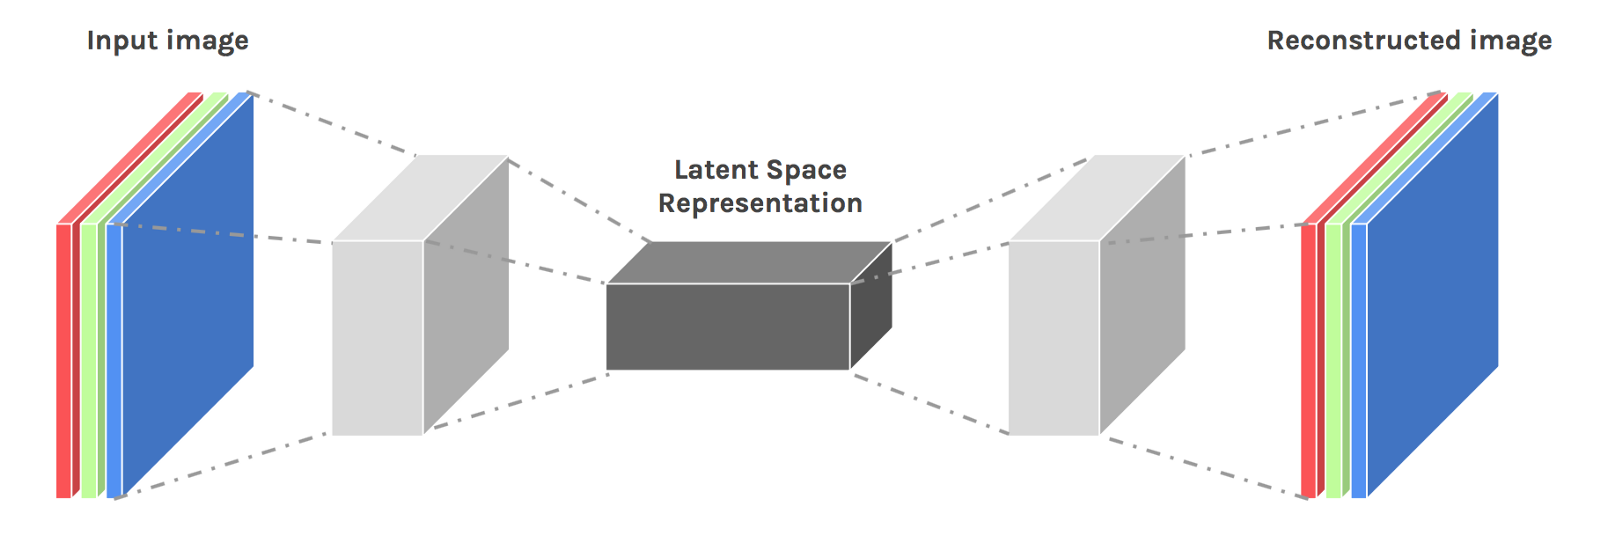

Here we will use LAB color space.
1. Input image is a black-white image, which is L channel.
2. The latent space is a representation of image in a smaller dimension. 
3. The Reconstructed image is a color input image, which is A,B channels. </br>
All this happens as the model compares the reconstructed image with the color image(the one we have). By comparing is to find mean square error(i.e mse(AB_channels, models_output_AB_channels)) between images and then back prop to minimize this error.

In [ ]:
import torch, os,cv2, torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,6)

## Download Dataset

In [ ]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/3f83gxmv57-2.zip
!unzip -qq /content/3f83gxmv57-2.zip
!unzip -qq /content/"Citrus Plant Dataset"/Citrus.zip

--2021-03-18 05:20:31--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/3f83gxmv57-2.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.62.144
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.62.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66932143 (64M) [application/octet-stream]
Saving to: ‘3f83gxmv57-2.zip’

3f83gxmv57-2.zip    100%[===================>]  63.83M  25.3MB/s    in 2.5s    

2021-03-18 05:20:34 (25.3 MB/s) - ‘3f83gxmv57-2.zip’ saved [66932143/66932143]



In [ ]:
images_paths = []
for f in os.listdir('/content/Citrus/Leaves'):
  images_paths.extend(['/content/Citrus/Leaves/'+f+'/'+x for x in os.listdir('/content/Citrus/Leaves/'+f)])

Show color images

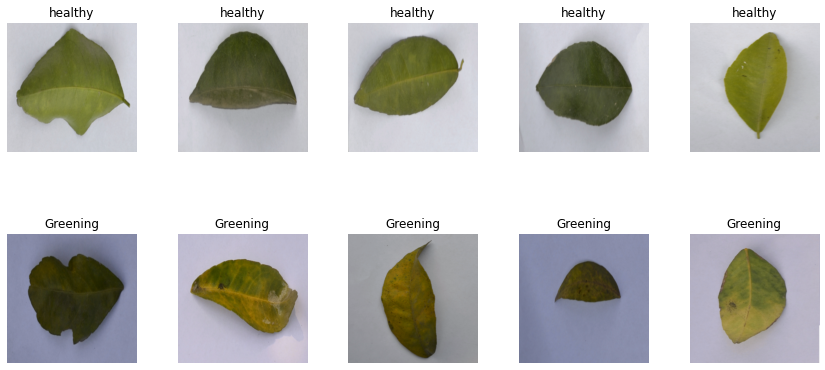

In [ ]:
images_dirs = ['/content/Citrus/Leaves/healthy/', '/content/Citrus/Leaves/greening/']
sample_imgs = [images_dirs[0]+i for i in os.listdir(images_dirs[0])[:5]]
sample_imgs = sample_imgs + [images_dirs[1]+i for i in os.listdir(images_dirs[1])[:5]]
sample_labels = ["healthy"]*5 + ["Greening"]*5

r,c = 2,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0

for i in range(r):
  for j in range(c):
    img = cv2.imread(sample_imgs[a])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) 
    img1 = img[:,:,0]
    img2 = img[:,:,1]
    img3 = img[:,:,2]
    img = cv2.merge((img1, img2, img3))
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB) 
    axs[i,j].imshow(img)
    axs[i,j].set_title(sample_labels[a])
    axs[i,j].axis('off')
    a+=1

Show b/w images

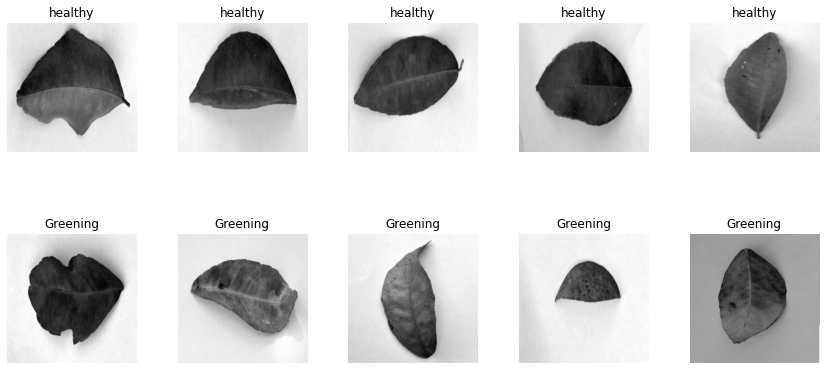

In [ ]:
r,c = 2,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0

for i in range(r):
  for j in range(c):
    img = cv2.imread(sample_imgs[a])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) 
    im = img[:,:,0]
    axs[i,j].imshow(im, cmap='gray')
    axs[i,j].set_title(sample_labels[a])
    axs[i,j].axis('off')
    a+=1

## Prepare Dataloader

In [ ]:
class MakeDataset(Dataset):
    def __init__(self,images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB) 
        image = cv2.resize(image,(256,256)) 
        input_image = self.transform(image[:,:,0])  # L channel
        output_image = self.transform(image[:,:,1:]) # A,B channel

        return input_image, output_image

In [ ]:
BATCH_SIZE = 64

img_transform = transforms.Compose([                              
    transforms.ToTensor()
])

train_paths, test_paths = train_test_split(images_paths, test_size=0.1)

train_dataset = MakeDataset(train_paths, img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = MakeDataset(test_paths, img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([1, 256, 256]), torch.Size([2, 256, 256]))

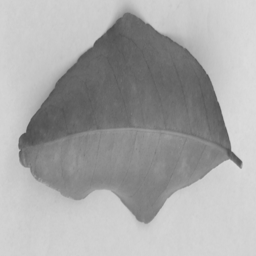

In [ ]:
# sample b/w image from loader
img = train_dataset[0][0].mul(255).permute(1, 2, 0).byte().numpy()
img = img[:,:,0]
Image.fromarray(img)

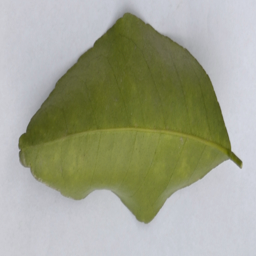

In [ ]:
# sample image from loader
img = train_dataset[0][0].mul(255).permute(1, 2, 0).byte().numpy()
img1 = train_dataset[0][1].mul(255).permute(1, 2, 0).byte().numpy()
colorized = cv2.merge((img, img1))
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2RGB)
Image.fromarray(colorized)

To build image coloring auto-encoder, we input LAB images 1st channel(L lightness) for b/w image and output 2 channels(A nd B).

In [ ]:
# test, check, build auto encoder

print('input shape', dataset[0][0].shape)
x = nn.Conv2d(1, 128, 5, stride=2, padding=1)(dataset[0][0].reshape(1, 1, 256, 256))
x = nn.ReLU()(x)
x = nn.Conv2d(128, 128, 3, stride=1, padding=1)(x)
x = nn.ReLU()(x)
x = nn.MaxPool2d(kernel_size=2)(x)

x = nn.Conv2d(128, 128, 3, stride=1, padding=1)(x)
x = nn.ReLU()(x)
x = nn.Conv2d(128, 64, 3, stride=1, padding=1)(x)
x = nn.ReLU()(x)

x = nn.Conv2d(64, 64, 3, stride=1, padding=1)(x)
x = nn.ReLU()(x)

print('latent space shape', x.shape)

x = nn.ConvTranspose2d(64, 32, 2, stride=2)(x) # input latent space to decoder
x = nn.ReLU()(x)
x = nn.ConvTranspose2d(32, 32, 2, stride=1)(x)
x = nn.ReLU()(x)

x = nn.ConvTranspose2d(32, 16, 2, stride=2)(x)
x = nn.ReLU()(x)
x = nn.ConvTranspose2d(16, 16, 2, stride=1)(x)
x = nn.ReLU()(x)

x = nn.ConvTranspose2d(16, 2, 2, stride=1)(x)
print('decoder shape', x.shape) # (decoder output) make sure it is same size as input image

input shape torch.Size([1, 256, 256])
latent space shape torch.Size([1, 64, 63, 63])
decoder shape torch.Size([1, 2, 256, 256])


## Build Auto-Encoder

In [ ]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(nn.Conv2d(1, 128, 5, stride=2, padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(128, 128, 3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2),
                                      nn.Conv2d(128, 128, 3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(128, 64, 3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(64, 64, 3, stride=1, padding=1),
                                      nn.ReLU()
                                      )
        
        self.decoder = nn.Sequential(nn.ConvTranspose2d(64, 32, 2, stride=2),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(32, 32, 2, stride=1),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(32, 16, 2, stride=2),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(16, 16, 2, stride=1),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(16, 2, 2, stride=1),
                                      nn.Sigmoid() # 0,1 outputs
                                      )

    def forward(self, x):
      x = self.encoder(x)
      x1 = self.decoder(x)
      return x1     

## Training

In [ ]:
%%time

LR = 0.003
epochs = 30
print_epoch = 10
best_loss = 0.50
model_save_path = "/content/autoencoder1.bin"
model = AutoEncoder().cuda(0)
criterion = nn.MSELoss() # simple MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-7)

if os.path.isfile(model_save_path):
  save_m = torch.load(model_save_path)
  model.load_state_dict(save_m['model_state_dict'])
  optimizer.load_state_dict(save_m['optimizer_state'])
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, last_epoch=save_m['prev_epoch'], eta_min=1e-7)
  scheduler.load_state_dict(save_m['scheduler_state'])
  print('loaded')

train_step = len(train_dataset)/BATCH_SIZE
print("--Training Started--")
for epoch in range(1,epochs+1):
  running_loss = 0.0
  for bw_images, color_images in train_dataloader:
    optimizer.zero_grad()
    color_images, bw_images = color_images.cuda(0), bw_images.cuda(0)
    output_images = model(bw_images)
    loss = criterion(color_images, output_images) 
    running_loss+=loss.detach()       
    loss.backward()
    optimizer.step() 
  train_loss = running_loss/train_step

  scheduler.step()
  if train_loss < best_loss:
    best_loss = train_loss
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'prev_epoch': epoch
            }, model_save_path)
  if epoch % print_epoch == 0:
    print("Epoch:", epoch)
    print("Train Loss:", train_loss.item())  

print('')    
print("--Training Completed--")    
print("Best loss:", best_loss.item())

--Training Started--
Epoch: 10
Train Loss: 0.0018101850291714072
Epoch: 20
Train Loss: 0.0014671824174001813
Epoch: 30
Train Loss: 0.0012588649988174438

--Training Complete--
Best loss: 0.0012291179737076163
CPU times: user 1min 24s, sys: 26.8 s, total: 1min 51s
Wall time: 1min 57s


## Results

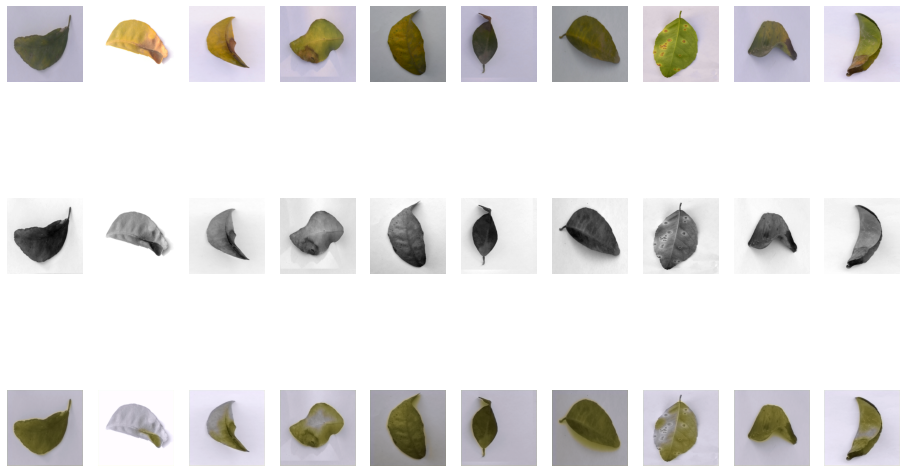

In [ ]:
if os.path.isfile('/content/autoencoder1.bin'):
  model.load_state_dict(torch.load(model_save_path)["model_state_dict"])

for bw_images, color_images in test_dataloader:  
  color_images, bw_images = color_images.cuda(0), bw_images.cuda(0)
  output_images = model(bw_images)
  break

ROWS, COLS = 3, 10
f, axs = plt.subplots(ROWS,COLS, figsize=(16,10))
a,b,c= 0,0,0

for i in range(ROWS):
  for j in range(COLS):

    if i == 0:  # original image
      im1 = bw_images[a].mul(255).permute(1, 2, 0).byte().detach().cpu().numpy()
      im2 = color_images[a].mul(255).permute(1, 2, 0).byte().detach().cpu().numpy() 
      colorized = cv2.merge((im1, im2))
      im = cv2.cvtColor(colorized, cv2.COLOR_LAB2RGB)
      axs[i,j].imshow(im)
      a+=1

    elif i == 1: # b/w image
      im = bw_images[b].mul(255).permute(1, 2, 0).byte().detach().cpu().numpy()  
      im = im[:,:,0]
      axs[i,j].imshow(im, cmap='gray')
      b+=1

    else: # output image
      im1 = bw_images[c].mul(255).permute(1, 2, 0).byte().detach().cpu().numpy() 
      im2 = output_images[c].mul(255).permute(1, 2, 0).detach().cpu().byte().numpy()
      colorized = cv2.merge((im1, im2))
      im = cv2.cvtColor(colorized, cv2.COLOR_LAB2RGB)
      axs[i,j].imshow(im)
      c+=1

    axs[i,j].axis('off')

Summary: As we can see there are improvements already, due to simplicity of this dataset the task was easy, but in most cases a bigger network, more training is essential. 
